In [1]:
import numpy as np
from GA.operators.export import *
from GA.utils.export import *

In [ ]:
class EVRP_GA:
    def __init__(self, filename, param_ga, config, binario=True, restricoes=False):
        self.evrp_data = read_evrp_file(filename)
        self.param_problema = parametros_problema(self.evrp_data, binario, restricoes)
        self.param_ga = param_ga
        self.config = config
        
        self.best_run = []
        self.best_dist = float('inf')
        self.population = []
        self.fitness = {}
        self.pais = []
        self.filhos = []
        self.new_pop = []
        
        # Contadores e histórico
        self.n_aval = 0  # Contador de avaliações
        self.historico_melhor_rota = []
        self.historico_melhor_distancia = []

        # Configuração dos operadores
        self.evaluation_methods = {
            'distancia': avaliacao_distancia_pura,
            'restricoes': avaliacao_distancia_restricoes,
            'rankeamento': avaliacao_rankeamento
        }

        self.selection_methods = {
            'roleta': selecao_roleta,
            'torneio': selecao_torneio,
            'rank': selecao_rank
        }
        
        self.crossover_methods = {
            'one_point': crossover_one_point,
            'two_point': crossover_two_point,
            'uniforme': crossover_uniforme
        }

        self.mutation_methods = {
            'bit_flip': mutacao_bit_flip,
            'swap': mutacao_swap,
            'inversao': mutacao_inversao,
            'scramble': mutacao_scramble,
            '': False
        }

        self.replacement_methods = {
            'completa': substituicao_completa,
            'elitimos': substituicao_elitismo,
            'steady_state': substituicao_steady_state,
        }

    def initialize(self):
        n_pop = self.param_ga['n_pop']
        self.population = [criar_rotas_aleatorias(self.evrp_data, self.param_problema['num_rotas_min'], self.param_problema['restricoes']) for _ in range(n_pop)]
        #print(f"Iniciou com: {len(self.population)} rotas")
    
    def evaluate(self):
        """Avalia a população e atualiza o contador de avaliações."""
        metodo = self.evaluation_methods[self.config['evaluation']]
        self.fitness = metodo(self.population, self.evrp_data)
        self.n_aval += len(self.population)  # Incrementa o contador
        #print(f"Avaliou {len(self.fitness)} rotas (Total de avaliações: {self.n_aval})")

    def selection(self):
        metodo = self.selection_methods[self.config['selection']]
        self.pais = metodo(self.population, self.fitness, self.param_ga['n_pais'])
        #print(f"Seleciou {len(self.pais)} pais")

    def crossover(self):
        self.filhos = crossover_completo(self.pais, self.evrp_data, n_filhos = self.param_ga['n_filhos'], num_rotas_min=self.param_problema['num_rotas_min'], tipo_crossover=self.config['crossover'], taxa_crossover=1, estacao=self.param_problema['restricoes'])
        #print(f"Gerou {len(self.filhos)} filhos")

    def mutation(self):
        if self.config['mutation'] == '': return
        self.filhos = aplicar_mutacao(self.filhos, self.evrp_data, self.param_problema['num_rotas_min'], metodo=self.config['mutation'], taxa_mutacao=0.1, estacao=self.param_problema['restricoes'])
        #print(f"Mutação em {len(self.filhos)} filhos")

    def replacement(self):
        fitness_filhos = avaliacao_rankeamento(self.filhos, self.evrp_data)
        self.new_pop = gerar_nova_populacao(self.population, self.filhos, self.fitness, fitness_filhos, metodo=self.config['replacement'], 
                         n_pop=self.param_ga['n_pop'], n_pais=self.param_ga['n_pais'], n_filhos=self.param_ga['n_filhos'], n_elite=5)
        #print(f"Finalizou com: {len(self.new_pop)} rotas")

    def registrar_melhoria_csv(self, onde):
        """Registra uma nova melhoria no CSV"""
        with open('melhores_resultados.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                self.n_aval,
                self.best_dist,
                onde,
                self.best_run
            ])
    
    def run(self):
        self.initialize()
        self.evaluate()
        criar_csv_vazio()  # Cria o CSV vazio no início
        
        while self.n_aval < self.param_ga['max_aval']:
            best_rota, best_dist = melhor_rota(self.population, self.evrp_data)
            if self.best_dist > best_dist:
                print("Pop", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('População Atual')
                
            self.historico_melhor_rota.append(best_rota)
            self.historico_melhor_distancia.append(best_dist)
            
            self.selection()
            self.crossover()
            best_rota, best_dist = melhor_rota(self.filhos, self.evrp_data)
            if self.best_dist > best_dist:
                print("Cross", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Crossover')
                
            self.mutation()
            best_rota, best_dist = melhor_rota(self.filhos, self.evrp_data)
            if self.best_dist > best_dist:
                print("Mut", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Mutação')
                
            self.replacement()
            self.population = self.new_pop
            self.evaluate()

        print(f"Parada atingida: {self.n_aval} avaliações realizadas.")
        return self.best_run
    
    def mostrar_historico(self):
        """Exibe o histórico de melhores distâncias por geração."""
        import matplotlib.pyplot as plt
        plt.plot(self.historico_melhor_distancia, marker='o')
        plt.xlabel('Geração')
        plt.ylabel('Melhor Distância')
        plt.title('Convergência do Algoritmo')
        plt.grid(True)
        plt.show()
        
        # Exibe detalhes
        for geracao, distancia in enumerate(self.historico_melhor_distancia):
            print(f"Geração {geracao}: {distancia:.2f}")

In [54]:
params_ga = {
    # Tamanho da população
    'n_pop': 50,                 # Número de indivíduos na população
    
    # Critérios de parada
    'n_geracoes': 100,           # Número máximo de gerações
    'max_aval': 25000,           # Número máximo de avaliações de fitness
    'tempo_max': 3600,           # Tempo máximo de execução em segundos (opcional)
    #'limite_convergencia': 20,   # Número de gerações sem melhoria para parar (opcional)
    
    # Taxas de operação
    'taxa_crossover': 1.0,       # Probabilidade de crossover (0.8-1.0)
    'taxa_mutacao': 0.1,         # Probabilidade de mutação (0.01-0.2)
    
    # Tamanhos relacionados
    'n_pais': 20,                # Número de pais selecionados (normalmente 40-50% de n_pop)
    'n_filhos': 30,              # Número de filhos gerados (normalmente 80-90% de n_pop)
    'n_elite': 20,                # Número de elites (para métodos que usam elitismo)
    
    # Parâmetros específicos do EVRP
    'num_rotas_min': 3,          # Número mínimo de rotas por solução
    'bits_por_cidade': None,     # Calculado automaticamente se None
    'considera_estacoes': False  # Se considera estações de recarga
}

config = {
    # Método de avaliação
    'evaluation': 'distancia',   # 'distancia', 'restricoes', 'rankeamento'
    
    # Método de seleção
    'selection': 'roleta',       # 'roleta', 'torneio', 'rank'
    'tamanho_torneio': 3,        # Quando usar seleção por torneio (2-5)
    
    # Método de crossover
    'crossover': 'one_point',    # 'one_point', 'two_point', 'uniforme'
    
    # Método de mutação
    'mutation': '',              # '', 'bit_flip', 'swap', 'inversao', 'scramble'
    
    # Método de substituição
    'replacement': 'elitismo',   # 'completa', 'elitismo', 'steady_state'
    
    # Parâmetros específicos de mutação
    'tamanho_bloco_mutacao': 3,  # Para mutações como inversão/scramble (tamanho do segmento)
    
    # Parâmetro específico para steady-state
    'n_substituir': 10           # Número de piores a substituir (para steady-state)
}

ga = EVRP_GA('E-n23-k3.evrp', params_ga, config)

In [ ]:
params_ga = {
    'n_pop': 100,                # População maior para mais diversidade
    'n_geracoes': 200,
    'max_aval': 25000*32,
    'taxa_crossover': 0.9,
    'taxa_mutacao': 0.05,        # Mutação baixa para evitar perturbações excessivas
    'n_pais': 25,
    'n_filhos': 75,
    'n_elite': 7,
    'num_rotas_min': 3,          # Definido pelo problema
    'limite_convergencia': 20    # Parar se não houver melhoria em 20 gerações
}

config = {
    'evaluation': 'rankeamento',  # Usar penalidades para restrições
    'selection': 'torneio',      # Torneio é mais eficiente para evitar convergência prematura
    'tamanho_torneio': 5,
    'crossover': 'two_point',    # Combinação mais equilibrada
    'mutation': 'swap',          # Mutação simples para preservar estrutura
    'replacement': 'elitismo'    # Mantém as melhores soluções
}

In [56]:
ga = EVRP_GA('E-n23-k3.evrp', params_ga, config)
rota = ga.run()

Pop 100 1069.2016750451548
Mut 180 1051.3554251475293
Cross 340 1029.9662662901883
Mut 420 985.2817412310728
Cross 660 980.7329650502504
Cross 740 965.1660399376908
Cross 820 959.546924080143
Mut 1220 942.5554403186653
Mut 1300 918.0733398302731
Cross 1540 901.0818560687954
Mut 1940 899.8020097018126
Mut 2100 898.5474079065408
Cross 2340 894.0899185261216
Mut 2420 886.799327190006
Cross 2740 883.9217657382691
Cross 2820 875.6213093124894
Mut 2820 850.1810124807381
Cross 2980 847.346482756784
Cross 3060 837.1783299689315
Cross 3140 829.1787674124106
Mut 3220 806.6330358148792
Mut 3940 797.3532582479542
Mut 4020 769.8216494978711
Mut 5060 755.3762920011144
Cross 5380 750.9865613475345
Mut 5460 744.3313108905733
Mut 7460 742.0384706611326
Mut 9380 737.40359592538
Mut 10020 735.1189266063102
Mut 11780 734.0951794239841
Mut 12260 718.0931273222334
Cross 12580 717.0693801399073
Mut 12980 707.1550969916439
Mut 15220 699.5702619724325
Mut 16740 698.6464445644287
Mut 18100 696.8465528943863
Mut

In [34]:
gerar_log(ga.evrp_data, ga.historico_melhor_distancia, ga.historico_melhor_rota)

664.8313820171286


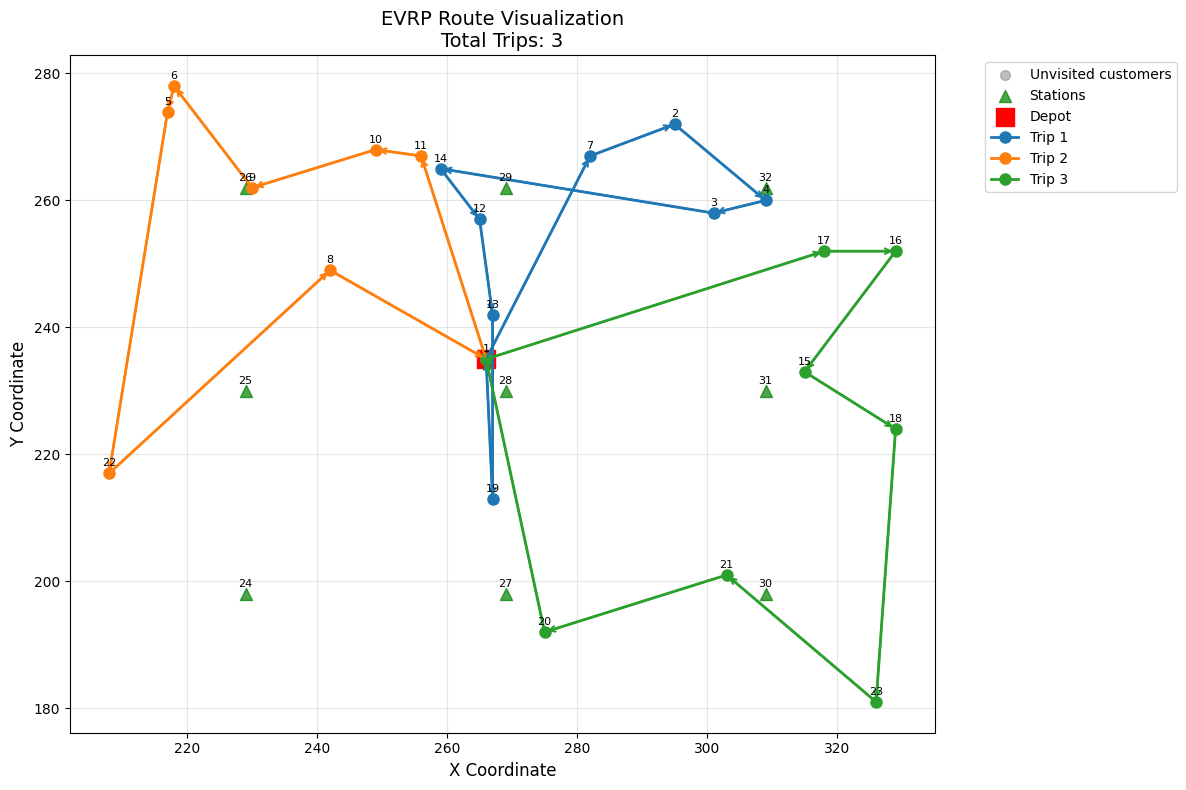

In [57]:
print(calcular_distancia_total(ga.evrp_data, rota))
plot_single_route_with_trips(ga.evrp_data, rota)